<a href="https://colab.research.google.com/github/heokwon/Data-Handling-for-segmentation/blob/main/Mosaic_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [ ]:
# !gdown 
# !unzip 

# Install

In [ ]:
!pip install fmutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fmutils: filename=fmutils-0.2.0-py3-none-any.whl size=7462 sha256=7bec764c09b9140d758f477e1c652a5ab57c5ba5c46337b620b42d2521ebbd9b
  Stored in directory: /root/.cache/pip/wheels/7a/a8/f3/98795e93b42056b75a9d6d190ebaab8c6e9c68432770a5d393
Successfully built fmutils


# Imports

In [ ]:
import os
import cv2
import numpy as np
import random
from PIL import Image
from tqdm import trange
import matplotlib.pyplot as plt
from fmutils import fmutils as fmu
from imgaug import augmenters as iaa

# Create Mosaic Dataset

In [ ]:
# -*- coding: utf-8 -*-
"""
Reference - https://github.com/Mr-TalhaIlyas/Mosaic-Augmentation-for-Segmentation
"""

def Resizer(img, w, h):
    seq = iaa.Sequential(
                    [
                    iaa.Resize({"longer-side": max(w, h),
                                "shorter-side": "keep-aspect-ratio"}),
                    
                    iaa.PadToFixedSize(width=w, height=h, position="uniform",
                                            pad_mode=['reflect', 'symmetric']),
                    
                    iaa.CropToFixedSize(width=w, height=h, position='uniform')
                    ])
    
    img = seq.augment_image(img)
    
    return img

def mosaic_augment(all_img_list, idxs, output_size, scale_range):
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    # scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    # scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    scale_x = scale_range[0] +(scale_range[1] - scale_range[0])
    scale_y = scale_range[0] +(scale_range[1] - scale_range[0])
    divid_point_x = int(scale_x * output_size[1])
    divid_point_y = int(scale_y * output_size[0])

    for i, idx in enumerate(idxs):
        path = all_img_list[idx]
        

        img = cv2.imread(path)
        if i == 0:  # top-left
            #img = cv2.resize(img, (divid_point_x, divid_point_y))
            img = Resizer(img, divid_point_x, divid_point_y)
            output_img[:divid_point_y, :divid_point_x, :] = img
            

        elif i == 1:  # top-right
            #img = cv2.resize(img, (output_size[1] - divid_point_x, divid_point_y))
            img = Resizer(img, output_size[1] - divid_point_x, divid_point_y)
            output_img[:divid_point_y, divid_point_x:output_size[1], :] = img
            
        elif i == 2:  # bottom-left
            #img = cv2.resize(img, (divid_point_x, output_size[0] - divid_point_y))
            img = Resizer(img, divid_point_x, output_size[0] - divid_point_y)
            output_img[divid_point_y:output_size[0], :divid_point_x, :] = img
            
        else:  # bottom-right
            #img = cv2.resize(img, (output_size[1] - divid_point_x, output_size[0] - divid_point_y))
            img = Resizer(img, output_size[1] - divid_point_x, output_size[0] - divid_point_y)
            output_img[divid_point_y:output_size[0], divid_point_x:output_size[1], :] = img
            

    return output_img

In [ ]:
# !rm -rf mosaic_images
# !rm -rf mosaic_masks
!mkdir mosaic_768
!mkdir /content/mosaic_768/mosaic_images
!mkdir /content/mosaic_768/mosaic_masks

In [ ]:
img_dir = '/content/conv_768_dataset/images/'
mask_dir = '/content/conv_768_dataset/masks/'
no_of_imgs = 2000
OUTPUT_SIZE = (768, 768) 
SCALE_RANGE = (0.5, 0.5)

img_paths =  fmu.get_all_files(img_dir)
mask_paths = fmu.get_all_files(mask_dir)
# print(img_paths)
# print(mask_paths)

for i in trange(no_of_imgs):
    idxs = random.sample(range(len(img_paths)), 4)
    
    new_image = mosaic_augment(img_paths, idxs,
                               OUTPUT_SIZE, SCALE_RANGE)
    new_masks = mosaic_augment(mask_paths, idxs,
                               OUTPUT_SIZE, SCALE_RANGE)
    
    cv2.imwrite(f'/content/mosaic_768/mosaic_images/{i}.png', new_image)
    cv2.imwrite(f'/content/mosaic_768/mosaic_masks/{i}.png', new_masks)

100%|██████████| 2000/2000 [10:18<00:00,  3.24it/s]


In [ ]:
from PIL import Image
mask_src='/content/mosaic_768/mosaic_masks/'
for mask in os.listdir(mask_src):
    mask_dir=os.path.join(mask_src,mask)
    im_gray=Image.open(mask_dir).convert("L")
    im_gray.save(mask_src+mask)

In [ ]:
test=Image.open('/content/mosaic_768/mosaic_masks/0.png')
test.mode

'L'

# Test

530 530


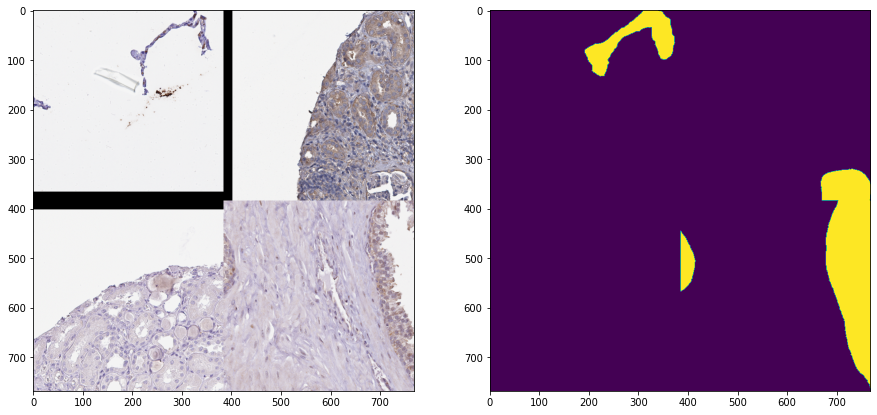

95 95


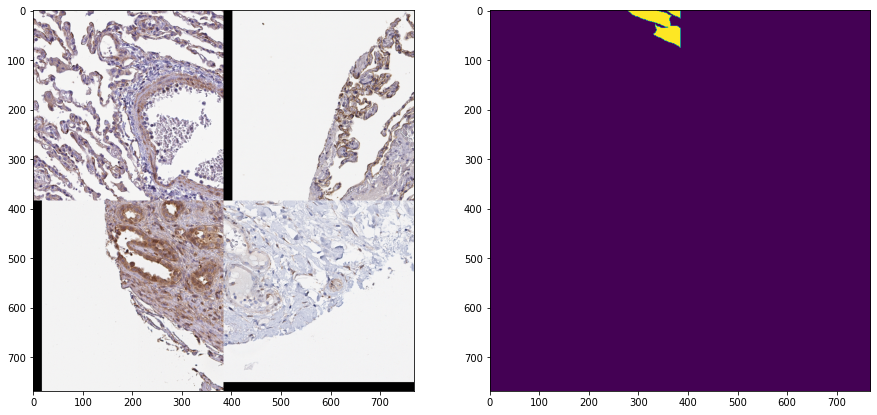

1032 1032


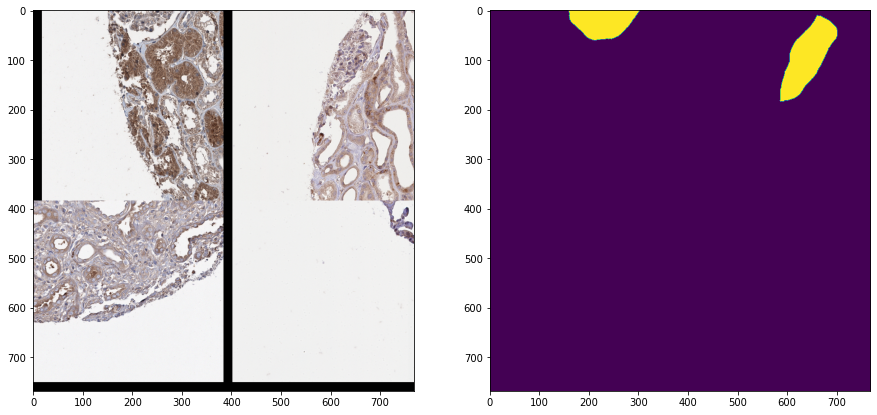

1746 1746


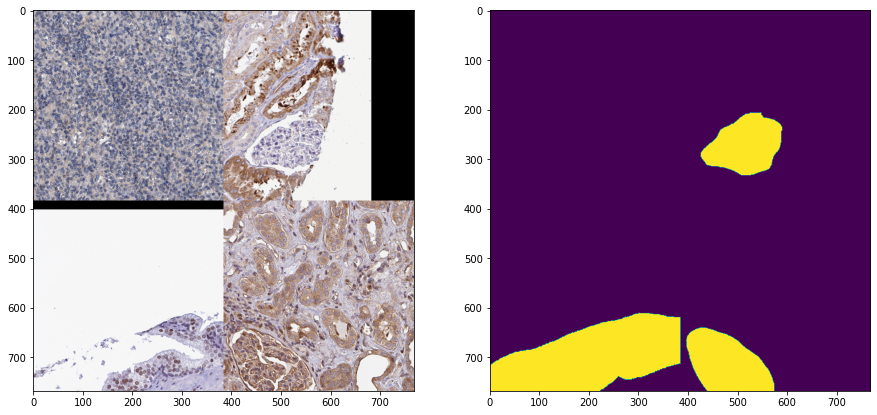

1319 1319


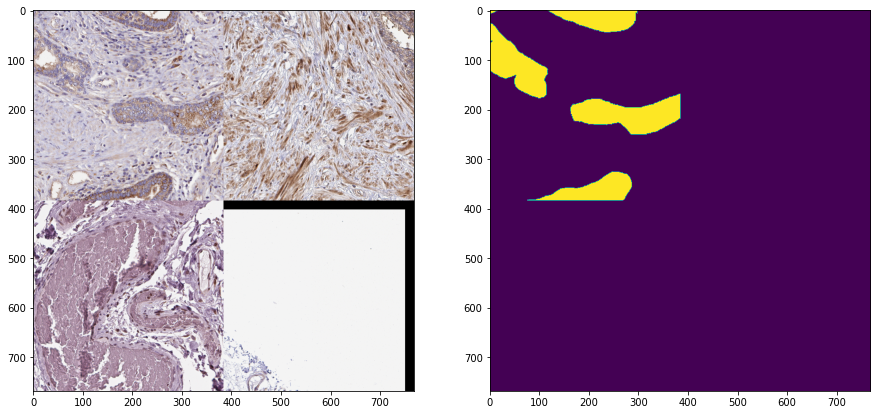

1288 1288


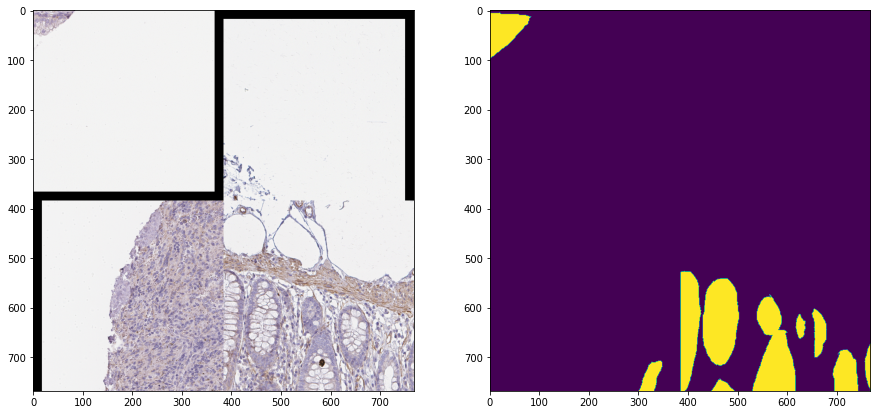

1883 1883


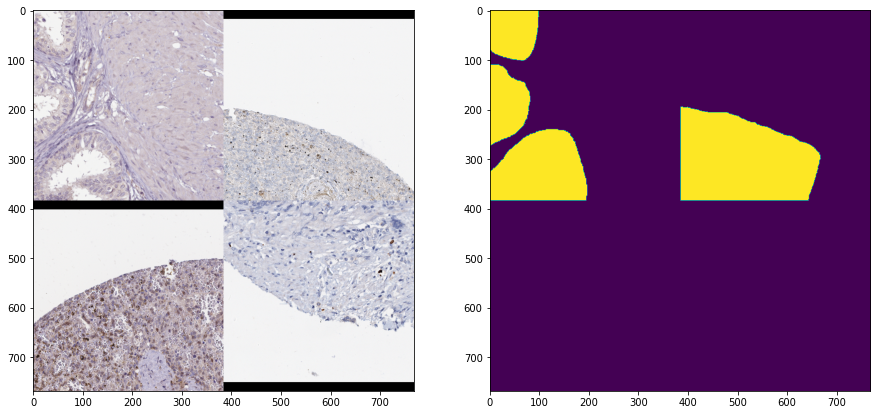

323 323


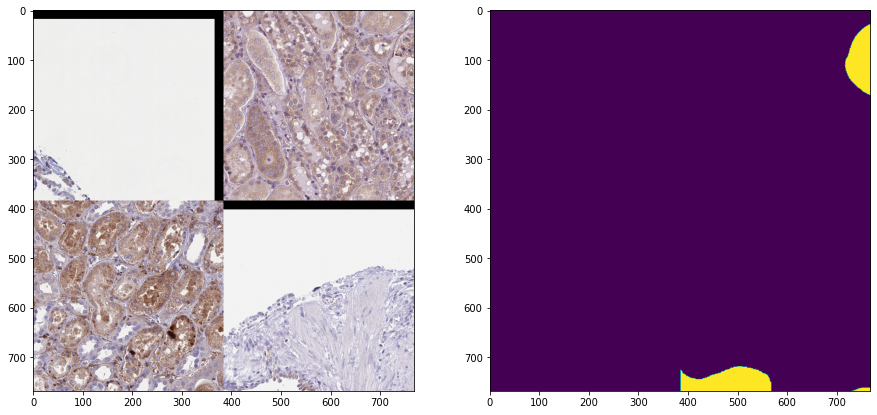

1200 1200


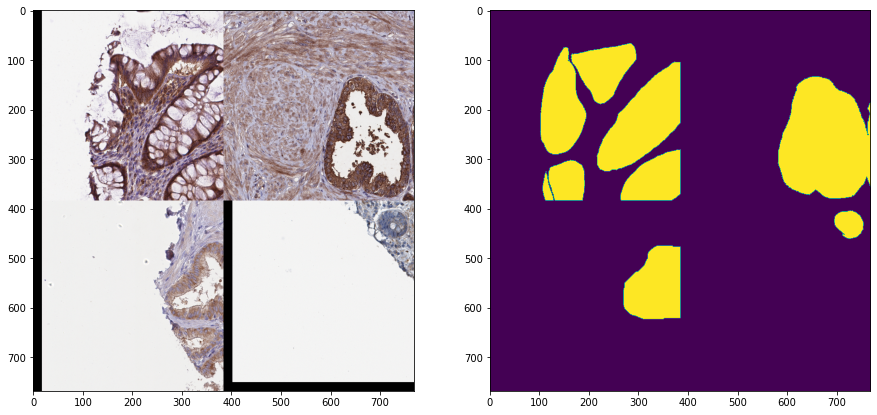

675 675


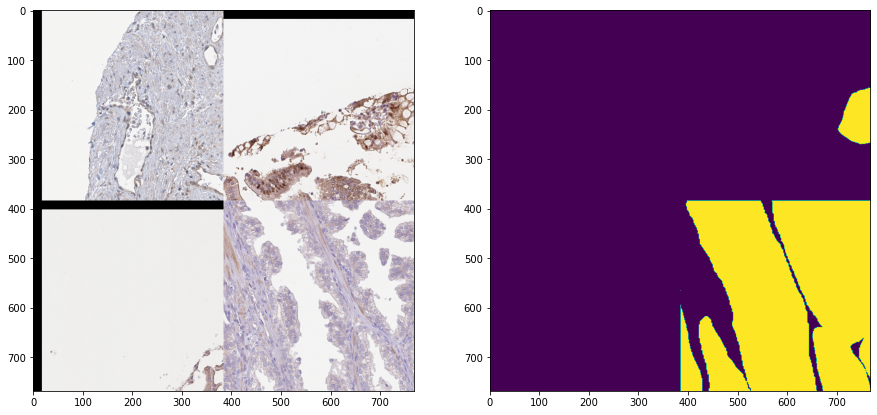

1905 1905


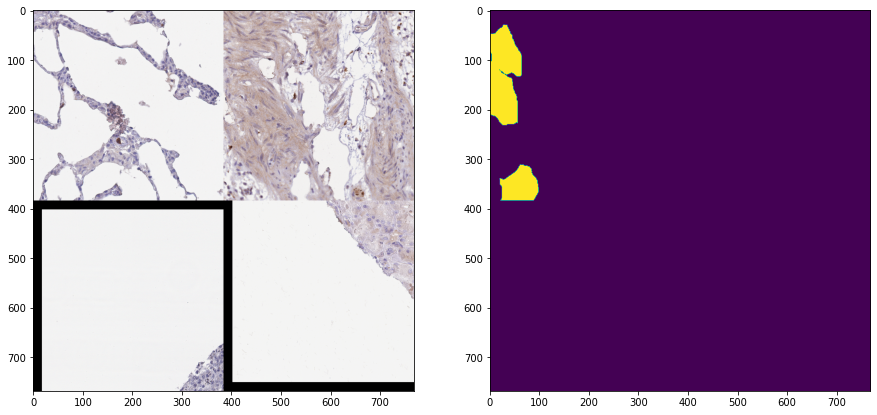

575 575


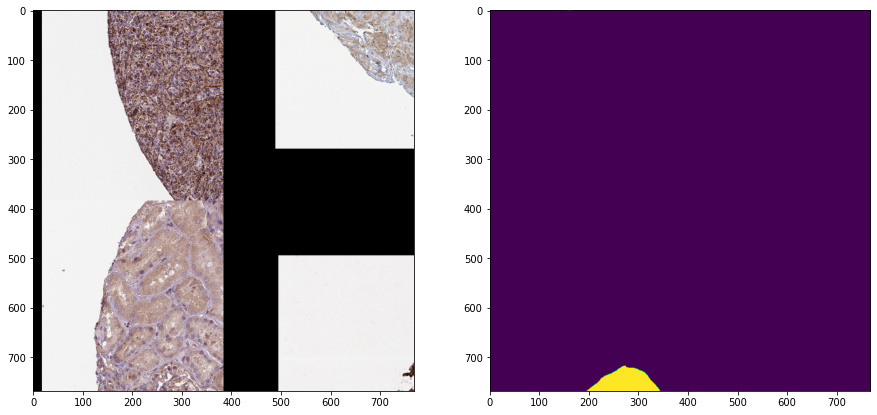

1802 1802


KeyboardInterrupt: ignored

In [ ]:
## inference

img_path='/content/mosaic_768/mosaic_images/'
mask_path='/content/mosaic_768/mosaic_masks/'
img_lst=os.listdir(img_path)
mask_lst=os.listdir(mask_path)

for img,mask in zip(img_lst, mask_lst):
    img_name=img.split('.')[0]
    mask_name=mask.split('.')[0]
    img_dir=os.path.join(img_path,img)
    mask_dir=os.path.join(mask_path,mask)
    
    image=Image.open(img_dir)
    mask_img=Image.open(mask_dir)
    mask_img=np.array(mask_img)
    mask_img=mask_img*255
    mask_img=Image.fromarray(mask_img)

    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask_img)
    print(img_name,mask_name )
    plt.show()

In [ ]:
## Reference - https://github.com/Mr-TalhaIlyas/Mosaic-Augmentation-for-Segmentation

In [ ]:
!mkdir mosaic_256_2000
!mv /content/mosaic_images /content/mosaic_256_2000
!mv /content/mosaic_masks /content/mosaic_256_2000
# !zip mosaic_256_2000.zip -r ./mosaic_256_2000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import natsort

id=[]
path='/content/mosaic_256_2000/mosaic_images/'
lst=os.listdir(path)
lst=natsort.natsorted(lst)
for ids in lst:
    f_name=ids.split('.')[0]
    id.append(f_name)

In [ ]:
id

In [ ]:
df=pd.DataFrame(id)
df

0
0        0
1        1
2        2
3        3
4        4
...    ...
1995  1995
1996  1996
1997  1997
1998  1998
1999  1999

[2000 rows x 1 columns]

In [ ]:
df.columns=["id"]

In [ ]:
df

id
0        0
1        1
2        2
3        3
4        4
...    ...
1995  1995
1996  1996
1997  1997
1998  1998
1999  1999

[2000 rows x 1 columns]

In [ ]:
df.to_csv('train.csv',index=False)

In [ ]:
!rm -rf /content/mosaic_256_2000/.ipynb_checkpoints

In [ ]:
# !mv /content/train.csv /content/mosaic_256_2000
!zip mosaic_256_2000.zip -r ./mosaic_256_2000

In [ ]:
!mv /content/mosaic_256_2000.zip /content/drive/MyDrive/data